In [2]:
# 가우스 잡음 추가 함수
import matplotlib.pyplot as plt
import numpy as np
import torch

from torchvision.datasets.mnist import MNIST
from torchvision.transforms import ToTensor

# 가우스 노이즈
# noiy_pixel = original_pixel + N(0, e = scale)
# 평균 = 0 : 픽셀을 전체적으로 밝히거나 어둡게 하지 않음
# 표준편차 = scale : 값이 클수록 노이즈가 강해짐
# 0.8 -> 노이즈의 양 많고 숫자 일부를 흐릿

In [3]:
def gaussian_noise(x, scale=0.8):
    gaussian_data_x = x + np.random.normal(
        loc=0,scale = scale, size=x.shape
    )
    gaussian_data_x = np.clip(gaussian_data_x, 0., 1.)
    gaussian_data_x = torch.tensor(gaussian_data_x, dtype=torch.float32)
    return gaussian_data_x

In [4]:
training_data = MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)
test_data = MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)


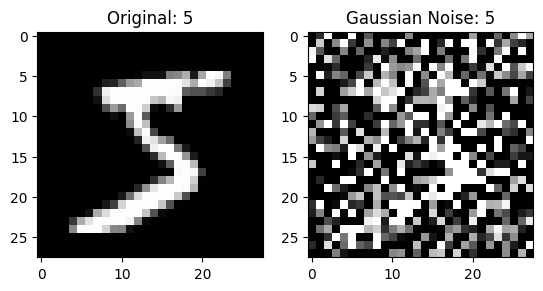

In [5]:
img, label = next(iter(training_data))
gaussian = gaussian_noise(img.numpy(), scale=0.8)

plt.subplot(1, 2, 1)
plt.imshow(img.squeeze(), cmap='gray')
plt.title(f'Original: {label}')
plt.subplot(1, 2, 2)
plt.imshow(gaussian.squeeze(), cmap='gray')
plt.title(f'Gaussian Noise: {label}')
plt.show()

In [6]:
for data, label in training_data:
    noisy_data = gaussian_noise(data.numpy(), scale=0.8)
    print(noisy_data.shape)
    break

torch.Size([1, 28, 28])


In [7]:
# 학습용 데이터 셋
from torch.utils.data import DataLoader, Dataset
class Denoise(Dataset):
    def __init__(self):
        self.mnist = MNIST(
            root="data",
            train=True,
            download=True,
            transform=ToTensor()
        )
        self.data = []
        for data, label in self.mnist:
            noisy = gaussian_noise(data)
            self.data.append(noisy)
            
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data = self.data[idx]
        label = self.mnist.data[idx]
        return data, label
    

In [8]:
# 합성곱 기본 블럭
import torch.nn as nn
# conv-relu-conv-relu
class BasicBlock(nn.Module):
    def __init__(self, in_channel, out_channel,hidden_channel):
        super(BasicBlock,self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channel, hidden_channel,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_channel, out_channel,kernel_size=3,padding=1),
            nn.ReLU()
        )
    def forward(self,x):
        return self.model(x)

In [9]:
sample_data = torch.randn(1, 1, 28, 28)
sample_model = BasicBlock(1, 20, 10)
sample_model(sample_data).shape

torch.Size([1, 20, 28, 28])

In [10]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.conv1 = BasicBlock(1,16,16)
        self.conv2 = BasicBlock(16,8,8)
        self.pool = nn.AvgPool2d(2)
    def forward(self, x):
        x = self.pool(self.conv1(x)) # 1,16,14,14
        out = self.pool(self.conv2(x)) # 1, 8,7,7
        return out

In [11]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        self.conv1 = BasicBlock(8,8,8)
        self.conv2 = BasicBlock(8,16,16)
        # 출력층
        self.conv3 = nn.Conv2d(16,1,kernel_size=3,padding=1)

        # 업셈플링 층
        self.upsampling1 = nn.ConvTranspose2d(8,8,kernel_size=2, stride=2)
        self.upsampling2 = nn.ConvTranspose2d(16,16,kernel_size=2, stride=2)
    def forward(self,x):
        x = self.upsampling1(self.conv1(x))
        x = self.upsampling2(self.conv2(x))
        out = self.conv3(x)
        return out

In [12]:
# CAE 오토인코더
# 인코더와 디코더를 연결 : 인코더의 출력을 디코더의 입력으로 제공
class CAE(nn.Module):
    def __init__(self):
        super(CAE, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [13]:
from tqdm import tqdm
from torch.utils.data.dataloader import DataLoader
from torch.optim import Adam
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
training_dataset = Denoise()
training_loader = DataLoader(training_dataset, batch_size=64, shuffle=True)
model = CAE().to(device)
criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=0.001)

num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for data, label in tqdm(training_loader):
        data = data.to(device)
        label = label.to(device).unsqueeze(1).float()/255.0

        # 순전파
        output = model(data)
        loss = criterion(output, label)

        # 역전파 및 최적화
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(training_loader):.4f}')
torch.save(model.state_dict(), './data/cae_mnist.pth')

C:\Users\31799\AppData\Local\Temp\ipykernel_22084\4010335324.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  gaussian_data_x = x + np.random.normal(
C:\Users\31799\AppData\Local\Temp\ipykernel_22084\4010335324.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gaussian_data_x = torch.tensor(gaussian_data_x, dtype=torch.float32)
 66%|██████▋   | 622/938 [03:41<01:52,  2.81it/s]  


KeyboardInterrupt: 

In [ ]:
# 평가 ./data/cae_mnist.pth
import torch
from torchvision.datasets.mnist import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch.utils.data.dataloader import DataLoader
from torch.nn import MSELoss
criterion = MSELoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CAE().to(device)
model.load_state_dict(torch.load('./data/cae_mnist.pth'))
model.eval()
test_dataset = MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
with torch.no_grad():
    total_loss = 0
    for data, label in test_loader:
        data = data.to(device)
        label = label.to(device).unsqueeze(1).float()/255.0

        output = model(data)
        loss = criterion(output, label)
        total_loss += loss.item()
    print(f'Test Loss: {total_loss/len(test_loader):.4f}')

NameError: name 'CAE' is not defined

In [ ]:
# 시각화
import matplotlib.pyplot as plt